# Fundamental Matrix Estimation, Camera Calibration, Triangulation (Python)
## Usage
This code snippet provides an overall code structure and some interactive plot interfaces for the Fundamental Matrix Estimation, Camera Calibration, Triangulation section of MP 3. We outline the required functionalities step by step. Feel free to make modifications on the starter code if it's necessary.

## Package installation
- You will need [GUI backend](https://matplotlib.org/faq/usage_faq.html#what-is-a-backend) to enable interactive plots in `matplotlib`.
- `numpy`
- `PIL`

# Common imports

In [1]:
%matplotlib inline
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import time
import skimage
import skimage.io
import cv2
import scipy
from scipy.spatial import distance

# Part (a)

In [2]:
def get_residual(F, p1, p2):
    """
    Function to compute the residual average residual on frame 2
    param: F (3x3): fundamental matrix: (pt in frame 2).T * F * (pt in frame 1) = 0
    param: p1 (Nx2): 2d points on frame 1
    param: p2 (Nx2): 2d points on frame 2
    """
    P1 = np.c_[p1, np.ones((p1.shape[0],1))].transpose()
    P2 = np.c_[p2, np.ones((p2.shape[0],1))].transpose()
    L2 = np.matmul(F, P1).transpose()
    L2_norm = np.sqrt(L2[:,0]**2 + L2[:,1]**2)
    L2 = L2 / L2_norm[:,np.newaxis]
    pt_line_dist = np.multiply(L2, P2.T).sum(axis = 1)
    return np.mean(np.square(pt_line_dist))

def plot_fundamental(ax, F, p1, p2, I):
    """
    Function to display epipolar lines and corresponding points
    param: F (3x3): fundamental matrix: (pt in frame 2).T * F * (pt in frame 1) = 0
    param: p1 (Nx2): 2d points on frame 1
    param: p2 (Nx2): 2d points on frame 2
    param: I: frame 2
    """
    N = p1.shape[0]
    P1 = np.c_[p1, np.ones((N,1))].transpose()
    P2 = np.c_[p2, np.ones((N,1))].transpose()
    L2 = np.matmul(F, P1).transpose() # transform points from 

    # the first image to get epipolar lines in the second image
    L2_norm = np.sqrt(L2[:,0]**2 + L2[:,1]**2)
    L2 = L2 / L2_norm[:,np.newaxis]
    pt_line_dist = np.multiply(L2, P2.T).sum(axis=1)
    closest_pt = p2 - (L2[:,0:2]*pt_line_dist[:,np.newaxis])

    # Find endpoints of segment on epipolar line (for display purposes).
    # offset from the closest point is 10 pixels
    pt1 = closest_pt - np.c_[L2[:,1], -L2[:,0]]*10 
    pt2 = closest_pt + np.c_[L2[:,1], -L2[:,0]]*10

    # Display points and segments of corresponding epipolar lines.
    # You will see points in red corsses, epipolar lines in green 
    # and a short cyan line that denotes the shortest distance between
    # the epipolar line and the corresponding point.
    ax.set_aspect('equal')
    ax.imshow(np.array(I))
    ax.plot(p2[:,0],p2[:,1],  '+r')
    ax.plot([p2[:,0], closest_pt[:,0]],[p2[:,1], closest_pt[:,1]], 'r')
    ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')

In [3]:
# write your code here for part estimating essential matrices
def fit_fundamental(matches, iterations=5):
    """
    Solves for the fundamental matrix using the matches with unnormalized method.
    """
    # input: matches: size = N x 4 is the pixel coordinates of N matches points
    # iteration: RANSAC interations
    # threhold: inlier threhold
    # in this method, we will use the RANSAC algorithm to estimate the best F matrix
    # also we will use 8-point algorithm to construct Af = 0 and solve for f
    # F should be a rank 2 matrix
    N = len(matches)
    min_residue = np.inf
    cur_pairs_list = [x for x in range(N)]
    best_F = None
    # first find 8 random point-pairs from matches_array
    for i in range(iterations):
        A = []
        random.shuffle(cur_pairs_list)
        for j in range(8):
            pair = cur_pairs_list[j]
            u1, v1, u2, v2 = matches[pair]
            A.append([u2*u1, u2*v1, u2, v2*u1, v2*v1, v2, u1, v1, 1])
        A = np.array(A)
        # solve for Af = 0 using svd
        u, s, vh = np.linalg.svd(A)
        # F = np.append(vh[-1], 1).reshape(3, 3)
        F = vh[-1].reshape(3, 3)
        # for F, we need to enforce a rank-2 constraint
        uf, sf, vhf = np.linalg.svd(F)
        sf[-1] = 0
        F = uf @ np.diag(sf) @ vhf
        
        # test the behavior of F
        pt1_2d = matches[:, :2]
        pt2_2d = matches[:, 2:]
        v2 = get_residual(F, pt1_2d, pt2_2d)
        v1 = get_residual(F.T, pt2_2d, pt1_2d)
        if (v1 + v2 < min_residue):
            min_residue = v1 + v2
            best_F = F
    return best_F
    

def normalize(points):
    # points is N x 2 matrix with N points
    # we need to return the new location of these points as well as the transformation matrix
    # transformation matrix T will look like:
    # f, 0, -f * shift_x
    # 0, f, -f * shift_y
    # 0, 0,           1
    # f is the scaling factor
    N = len(points)
    mean = np.mean(points, axis=0)
    mean_x, mean_y = mean
    # mean_x and mean_y should be the translation
    # now we need to find the factor f
    dist = np.sum((points - mean) ** 2)
    f = np.sqrt(2 / (dist / N))
    T = np.array([[f, 0, -f * mean_x],
                  [0, f, -f * mean_y],
                  [0, 0,           1]])
    new_points = T @ np.hstack((points, np.ones((N, 1)))).T
    return new_points[0:2].T, T
    
    
def fit_fundamental_normalized(matches, iterations=10):
    """
    Solve for the fundamental matrix using the matches with normalized method.
    """
    # first, we need to scale the matches points so that they are centered at their centriod
    # and the mean square distances of each points to the image centroid is 2
    # then apply the non-normalized algorithm and apply the transformation matrix
    p1, T1 = normalize(matches[:, 0:2])
    p2, T2 = normalize(matches[:, 2:4])
    new_matches = np.hstack((p1, p2))
    F = fit_fundamental(new_matches, iterations=iterations)
    return T2.T @ F @ T1

In [7]:
def parta(image):
    name = 'library' if image == 0 else 'lab'
    I1 = Image.open('./data/Q2/{:s}1.jpg'.format(name))
    I2 = Image.open('./data/Q2/{:s}2.jpg'.format(name))
    matches = np.loadtxt('./data/Q2/{:s}_matches.txt'.format(name))
    N = len(matches);
    
    ## Display two images side-by-side with matches
    ## this code is to help you visualize the matches, you don't need
    ## to use it to produce the results for the assignment
    I3 = np.zeros((I1.size[1],I1.size[0]*2,3))
    I3[:,:I1.size[0],:] = I1;
    I3[:,I1.size[0]:,:] = I2;
    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_aspect('equal')
    ax.plot(matches[:,0],matches[:,1],  '+r')
    ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
    ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
    ax.imshow(np.array(I3).astype(np.uint8))
    plt.show()
        
    # non-normalized method
    F = fit_fundamental(matches)
    print('non-normalized method, fundamental matrix is')
    print(F)
    pt1_2d = matches[:, :2]
    pt2_2d = matches[:, 2:]
    v2 = get_residual(F, pt1_2d, pt2_2d)
    v1 = get_residual(F.T, pt2_2d, pt1_2d)
    print('{:s}: residual in frame 2 (non-normalized method) = '.format(name), v2)
    print('{:s}: residual in frame 1 (non-normalized method) = '.format(name), v1)
    print('{:s}: residual combined   (non-normalized method) = '.format(name), (v1+v2)/2)
    # Plot epipolar lines in image I2
    fig, ax = plt.subplots()
    plot_fundamental(ax, F, pt1_2d, pt2_2d, I2)
    # Plot epipolar lines in image I1
    fig, ax = plt.subplots()
    plot_fundamental(ax, F.T, pt2_2d, pt1_2d, I1)
    plt.show()
        
    # normalized method
    F = fit_fundamental_normalized(matches)
    print('normalized method, fundamental matrix is')
    print(F)
    pt1_2d = matches[:, :2]
    pt2_2d = matches[:, 2:]
    v2 = get_residual(F, pt1_2d, pt2_2d)
    v1 = get_residual(F.T, pt2_2d, pt1_2d)
    print('{:s}: residual in frame 2 (normalized method) = '.format(name), v2)
    print('{:s}: residual in frame 1 (normalized method) = '.format(name), v1)
    print('{:s}: residual combined   (normalized method) = '.format(name), (v1+v2)/2)
    # Plot epipolar lines in image I2
    fig, ax = plt.subplots()
    plot_fundamental(ax, F, pt1_2d, pt2_2d, I2)
    # Plot epipolar lines in image I1
    fig, ax = plt.subplots()
    plot_fundamental(ax, F.T, pt2_2d, pt1_2d, I1)

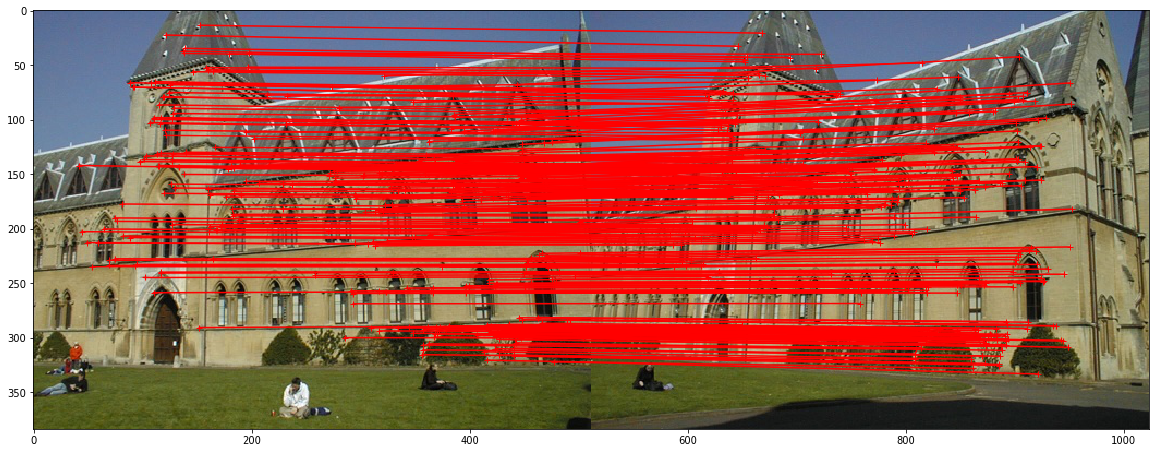

non-normalized method, fundamental matrix is
[[ 4.92771089e-06 -2.54935974e-05 -4.01356069e-03]
 [ 3.22189267e-05 -1.06672366e-06 -3.19902526e-02]
 [-2.04929889e-03  2.99086882e-02  9.99030422e-01]]
library: residual in frame 2 (non-normalized method) =  1.524947120387143
library: residual in frame 1 (non-normalized method) =  1.4821495373260811
library: residual combined   (non-normalized method) =  1.503548328856612


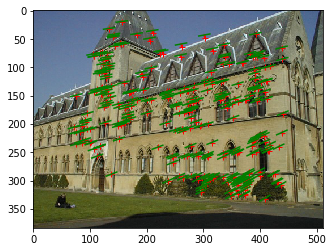

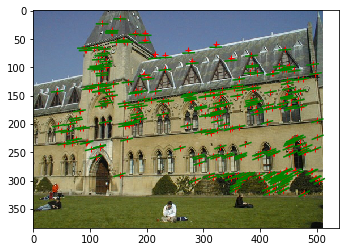

normalized method, fundamental matrix is
[[ 2.02185559e-06 -2.50317961e-05  2.01433668e-03]
 [ 2.30391589e-05 -1.02495020e-06 -1.31464086e-02]
 [-3.29469764e-03  1.32067183e-02  2.21136013e-01]]
library: residual in frame 2 (normalized method) =  0.5332482211772441
library: residual in frame 1 (normalized method) =  0.5454049051973185
library: residual combined   (normalized method) =  0.5393265631872813


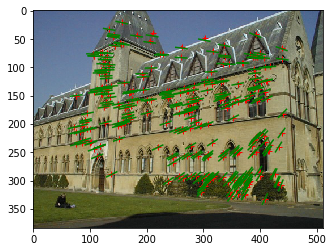

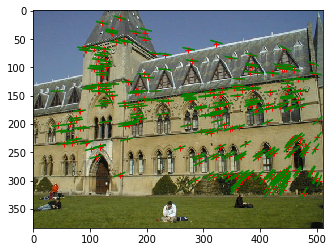

In [13]:
parta(0)

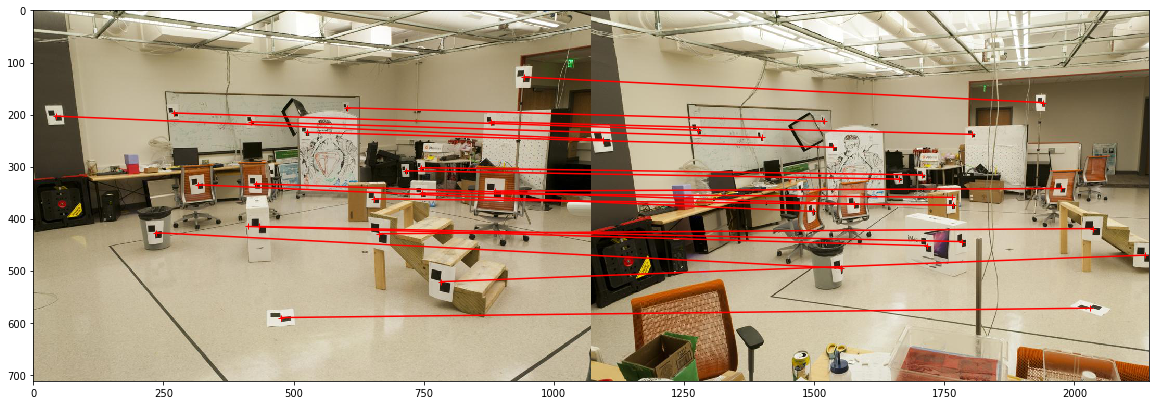

non-normalized method, fundamental matrix is
[[-2.97488424e-06  3.92258408e-05 -1.06704328e-02]
 [ 8.41708090e-06 -1.05886121e-05  6.65484617e-02]
 [ 3.77927328e-03 -8.45189128e-02  9.94132643e-01]]
lab: residual in frame 2 (non-normalized method) =  22.061034423751508
lab: residual in frame 1 (non-normalized method) =  34.54765537004669
lab: residual combined   (non-normalized method) =  28.3043448968991


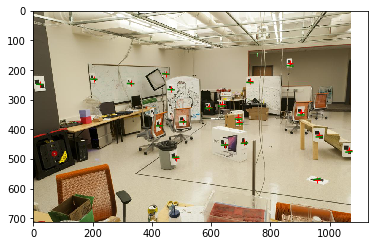

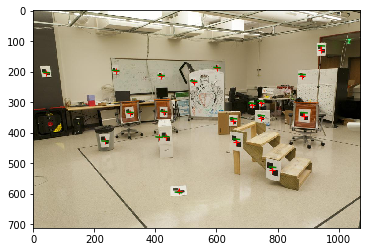

normalized method, fundamental matrix is
[[-1.53711836e-07  1.53409410e-06 -4.22075883e-04]
 [ 1.25406043e-06  5.64519216e-08  3.08952994e-03]
 [-1.66989861e-06 -4.45677037e-03  1.21366857e-01]]
lab: residual in frame 2 (normalized method) =  2.610215088599896
lab: residual in frame 1 (normalized method) =  3.8975373177498964
lab: residual combined   (normalized method) =  3.2538762031748965


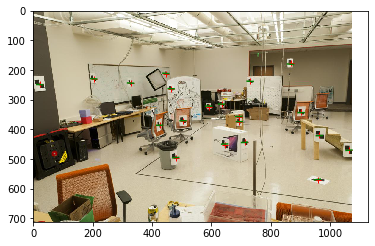

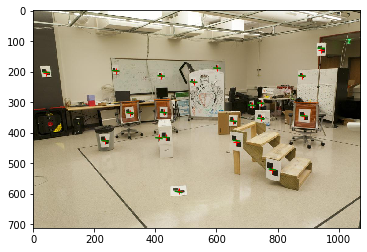

In [9]:
parta(1)

# Part (b)

In [25]:
def evaluate_points(M, points_2d, points_3d):
    """
    Visualize the actual 2D points and the projected 2D points calculated from
    the projection matrix
    You do not need to modify anything in this function, although you can if you
    want to
    :param M: projection matrix 3 x 4
    :param points_2d: 2D points N x 2
    :param points_3d: 3D points N x 3
    :return:
    """
    N = len(points_3d)
    points_3d = np.hstack((points_3d, np.ones((N, 1))))
    points_3d_proj = np.dot(M, points_3d.T).T
    u = points_3d_proj[:, 0] / points_3d_proj[:, 2]
    v = points_3d_proj[:, 1] / points_3d_proj[:, 2]
    residual = np.sum(np.hypot(u-points_2d[:, 0], v-points_2d[:, 1]))
    points_3d_proj = np.hstack((u[:, np.newaxis], v[:, np.newaxis]))
    return points_3d_proj, residual

# Write your code here for camera calibration (lab)
def camera_calibration(pts_2d, pts_3d, iterations=100):
    """
    write your code to compute camera matrix
    """
    
    # in this algorithm, we are given pts_2d N x 2 and pts_3d N x 3
    # we need to use 6 point pairs to construct x_i x (PX_i) = 0
    N = pts_2d.shape[0]
    min_residue = np.inf
    cur_pairs_list = [x for x in range(N)]
    best_P = None
    # first find 8 random point-pairs from matches_array
    for i in range(iterations):
        A = []
        random.shuffle(cur_pairs_list)
        # we need random 6 pairs
        for j in range(6):
            pair = cur_pairs_list[j]
            x, y = pts_2d[pair]
            X, Y, Z = pts_3d[pair]
            A.append([0, 0, 0, 0, X, Y, Z, 1, -y*X, -y*Y, -y*Z, -y])
            A.append([X, Y, Z, 1, 0, 0, 0, 0, -x*X, -x*Y, -x*Z, -x])
        A = np.array(A)
        # solve for Af = 0 using svd
        u, s, vh = np.linalg.svd(A)
        # F = np.append(vh[-1], 1).reshape(3, 3)
        P = vh[-1].reshape(3, 4)
        
        # test the behavior of F
        _, residual = evaluate_points(P, pts_2d, pts_3d)
        if (residual < min_residue):
            min_residue = residual
            best_P = P
    return best_P

def mean_square_dist(P, pts_2d, pts_3d):
    # this function returns the mean square distances between projected points and actual points
    # pts_2d: N x 2, pts_3d: N x 3
    N = pts_2d.shape[0]
    project = P @ np.hstack((pts_3d, np.ones((N, 1)))).T
    # project is matrix with size 3 x N
    project = project[0:2] / project[2:3]
    dist = np.sum((pts_2d - project.T) ** 2) / N
    return dist
    

# Load 3D points, and their corresponding locations in 
# the two images.
pts_3d = np.loadtxt('./data/Q2/lab_3d.txt')
matches = np.loadtxt('./data/Q2/lab_matches.txt')

# <YOUR CODE> print lab camera projection matrices:
lab1_proj = camera_calibration(matches[:, 0:2], pts_3d)
lab2_proj = camera_calibration(matches[:, 2:4], pts_3d)
print('lab 1 camera projection')
print(lab1_proj)

print('')
print('lab 2 camera projection')
print(lab2_proj)

# <YOUR CODE> evaluate the residuals for both estimated cameras
_, lab1_res = evaluate_points(lab1_proj, matches[:, 0:2], pts_3d)
print('residuals between the observed 2D points and the projected 3D points:')
print('residual in lab1:', lab1_res)
_, lab2_res = evaluate_points(lab2_proj, matches[:, 2:4], pts_3d)
print('residual in lab2:', lab2_res)

# find squared distance between projected points and actual 2D point
mean_square_dist1 = mean_square_dist(lab1_proj, matches[:, 0:2], pts_3d)
mean_square_dist2 = mean_square_dist(lab2_proj, matches[:, 2:4], pts_3d)
print('mean square distances between projected points and actual 2D points in lab1:', mean_square_dist1)
print('mean square distances between projected points and actual 2D points in lab2:', mean_square_dist2)

lab 1 camera projection
[[-3.10290200e-03 -1.43087200e-04  4.43163988e-04  9.79122394e-01]
 [-3.08554487e-04 -6.32347804e-04  2.76983889e-03  2.03222931e-01]
 [-1.67826727e-06 -2.74686362e-06  6.64572603e-07  1.32878934e-03]]

lab 2 camera projection
[[ 7.03307216e-03 -4.11924790e-03 -1.25006990e-03 -8.28091996e-01]
 [ 1.55422782e-03  1.01189648e-03 -7.27071594e-03 -5.60470980e-01]
 [ 7.67971318e-06  3.68909855e-06 -1.65110519e-06 -3.41001246e-03]]
residuals between the observed 2D points and the projected 3D points:
residual in lab1: 15.525182591135634
residual in lab2: 19.293705132691276
mean square distances between projected points and actual 2D points in lab1: 1.0577118398900547
mean square distances between projected points and actual 2D points in lab2: 1.5920666023126824


In [26]:
lib1_proj = np.loadtxt('./data/Q2/library1_camera.txt')
lib2_proj = np.loadtxt('./data/Q2/library2_camera.txt')
print('library1 camera projection')
print(lib1_proj)
print('library2 camera projection')
print(lib2_proj)

library1 camera projection
[[-4.5250208e+01  4.8215478e+02  4.0948922e+02  3.4440464e+03]
 [ 4.8858466e+02  2.7346374e+02 -1.3977268e+02  4.8030231e+03]
 [-1.9787463e-01  8.8042214e-01 -4.3093212e-01  2.8032556e+01]]
library2 camera projection
[[-5.9593834e+01  5.5643970e+02  2.3093716e+02  3.5683545e+03]
 [ 4.6419679e+02  2.2628430e+02 -1.9605278e+02  4.8734171e+03]
 [-1.9116708e-01  7.2057697e-01 -6.6650130e-01  2.8015392e+01]]


# Part (c)

In [27]:
# Write your code here for computing camera centers
def calc_camera_center(P):
    """
    write your code to get camera center in the world 
    from the projection matrix
    """
    # input P is the projected matrix for the camera
    # the cameara center should be in the null space of the projected matrix
    # i.e. PC = 0 where C = [X, Y, Z, 1].T
    # output should be C' = [X, Y, Z]
    u, s, vh = np.linalg.svd(P)
    C = vh[-1] / vh[-1][-1]
    return C[0:3]

# <YOUR CODE> compute the camera centers using 
# the projection matrices
lab1_c = calc_camera_center(lab1_proj)
lab2_c = calc_camera_center(lab2_proj)
print('lab1 camera center', lab1_c)
print('lab2 camera center', lab2_c)

# <YOUR CODE> compute the camera centers with the projection matrices
lib1_c = calc_camera_center(lib1_proj)
lib2_c = calc_camera_center(lib2_proj)
print('library1 camera center', lib1_c)
print('library2 camera center', lib2_c)

lab1 camera center [305.82848847 304.18700526  30.14392164]
lab2 camera center [303.03708886 307.12913135  30.4372474 ]
library1 camera center [  7.28863053 -21.52118112  17.73503585]
library2 camera center [  6.89405488 -15.39232716  23.41498687]


# Part (d)

Mean 3D reconstuction error for the lab data:  0.0359
2D reprojection error for the lab 1 data:  29.544169809244035
2D reprojection error for the lab 2 data:  4.716527674383048
2D reprojection error for the library 1 data:  51.53227122134838
2D reprojection error for the library 2 data:  81.28132134986555


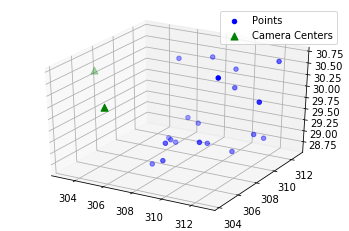

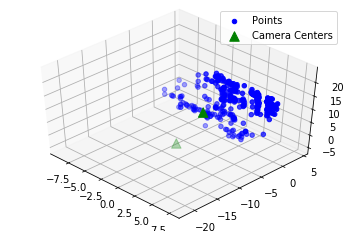

In [28]:
# Write your code here for triangulation
def outter_matrix(v):
    # given a vector v (2D, last element = 1)
    # we should output a matrix that represent the outter product from v
    # example: v x u = [v] @ u
    x, y = v
    z = 1
    return np.array([[0, -z, y],
                     [z, 0, -x],
                     [-y, x, 0]])

def triangulation(pt1, pt2, P1, P2):
    """
    write your code to triangulate the points in 3D
    """
    # use linear method to find the triangulation
    # we have pt1, pt2 (both of size N x 2) points in two camera
    # for each point, we need to estimate the 3D coordinate
    # output p: N x 3
    N = pt1.shape[0]
    # we have two equations:
    # 1. [pt1] @ P1 @ X = 0
    # 2. [pt2] @ P2 @ X = 0 -> merge together we have [[pt1]@P1 | [pt2]@P2] X = 0
    p = np.zeros((N, 3))
    for i in range(N):
        p1, p2 = pt1[i], pt2[i]
        A = np.vstack((outter_matrix(p1) @ P1, outter_matrix(p2) @ P2))
        # usd svd to find the null space of A
        u, s, vh = np.linalg.svd(A)
        C = vh[-1] / vh[-1][-1]
        p[i] = C[0:3]
   
    return p


def evaluate_points_3d(reconstruct, actual):
    """
    write your code to evaluate the triangulated 3D points
    """
    # given the reconstruct 3D points and actual 3D points
    # we need to find the distance
    diff = reconstruct - actual
    dist = np.sum(diff**2, axis=1)
    return np.sqrt(dist)

# triangulate the 3D point cloud for the lab data 
matches_lab = np.loadtxt('./data/Q2/lab_matches.txt')
lab_pt1 = matches_lab[:, 0:2]
lab_pt2 = matches_lab[:, 2:4]
points_3d_gt = np.loadtxt('./data/Q2/lab_3d.txt')
points_3d_lab = triangulation(lab_pt1, lab_pt2, lab1_proj, lab2_proj) # <YOUR CODE>
res_3d_lab = evaluate_points_3d(points_3d_lab, points_3d_gt) # <YOUR CODE>
print('Mean 3D reconstuction error for the lab data: ', round(np.mean(res_3d_lab), 5))
_, res_2d_lab1 = evaluate_points(lab1_proj, lab_pt1, points_3d_lab)
_, res_2d_lab2 = evaluate_points(lab2_proj, lab_pt2, points_3d_lab)
print('2D reprojection error for the lab 1 data: ', np.mean(res_2d_lab1))
print('2D reprojection error for the lab 2 data: ', np.mean(res_2d_lab2))
# visualization of lab point cloud
camera_centers = np.vstack((lab1_c, lab2_c))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d_lab[:, 0], points_3d_lab[:, 1], points_3d_lab[:, 2], c='b', label='Points')
ax.scatter(camera_centers[:, 0], camera_centers[:, 1],
           camera_centers[:, 2], c='g', s=50, marker='^', label='Camera Centers')
ax.legend(loc='best')

# triangulate the 3D point cloud for the library data
matches_lib = np.loadtxt('./data/Q2/library_matches.txt')
lib_pt1 = matches_lib[:, 0:2]
lib_pt2 = matches_lib[:, 2:4]
points_3d_lib = triangulation(lib_pt1, lib_pt2, lib1_proj, lib2_proj) # <YOUR CODE>
_, res_2d_lib1 = evaluate_points(lib1_proj, lib_pt1, points_3d_lib)
_, res_2d_lib2 = evaluate_points(lib2_proj, lib_pt2, points_3d_lib)
print('2D reprojection error for the library 1 data: ', np.mean(res_2d_lib1))
print('2D reprojection error for the library 2 data: ', np.mean(res_2d_lib2))
# visualization of library point cloud
camera_centers_library = np.vstack((lib1_c, lib2_c))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d_lib[:, 0], points_3d_lib[:, 1], points_3d_lib[:, 2], c='b', label='Points')
ax.scatter(camera_centers_library[:, 0], camera_centers_library[:, 1], 
           camera_centers_library[:, 2], c='g', s=90, 
           marker='^', label='Camera Centers')
ax.view_init(azim=-45, elev=45)
ax.legend(loc='best')

# Part (e)

In [89]:
def imread(fname):
    """
    read image into np array from file
    """
    return skimage.io.imread(fname)

def imread_bw(fname):
    """
    read image as gray scale format
    """
    return cv2.cvtColor(imread(fname), cv2.COLOR_BGR2GRAY)

def imshow(img):
    """
    show image
    """
    skimage.io.imshow(img)
    
def get_sift_data(img):
    """
    detect the keypoints and compute their SIFT descriptors with opencv library
    """
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    return kp, des

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    plot the match between two image according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')

In [128]:
def get_best_matches(img1, img2, num_matches):
    kp1, des1 = get_sift_data(img1)
    kp2, des2 = get_sift_data(img2)
    kp1, kp2 = np.array(kp1), np.array(kp2)
    
    # Find distance between descriptors in images
    dist = scipy.spatial.distance.cdist(des1, des2, 'sqeuclidean')
    
    # Write your code to get the matches according to dist
    # <YOUR CODE>
    # n1, n2 = dist.shape
    # at this time, we have a n1 by n2 matrix where dist[i][j] represents the distance between kp1[i] and kp2[j]
    # in this example, we want to find the lowest distance for the first num_matches pairs
    n1, n2 = dist.shape
    # now the max_heap stores the num_matches pairs
    data = []
    dist_f = dist.reshape(-1,)
    idx = np.argpartition(dist_f, num_matches)
    for index in idx[:num_matches]:
        i = index // n2
        j = index % n2
        x1, y1 = kp1[i].pt
        x2, y2 = kp2[j].pt
        data.append([x1, y1, x2, y2])
    return np.array(data)

def find_residual(F, p1, p2):
    P1 = np.c_[p1, np.ones((p1.shape[0],1))].transpose()
    P2 = np.c_[p2, np.ones((p2.shape[0],1))].transpose()
    L2 = np.matmul(F, P1).transpose()
    L2_norm = np.sqrt(L2[:,0]**2 + L2[:,1]**2)
    L2 = L2 / L2_norm[:,np.newaxis]
    pt_line_dist = np.multiply(L2, P2.T).sum(axis = 1)
    return np.absolute(pt_line_dist)

def ransac(data, threshold=10, iterations=10):
    """
    write your ransac code to find the best model, inliers, and residuals
    """
    N, _ = data.shape
    # first do the normalization
    p1, T1 = normalize(data[:, 0:2])
    p2, T2 = normalize(data[:, 2:4])
    new_data = np.hstack((p1, p2))
    max_inlier = 0
    best_F = None
    best_data = None
    residue = 0
    cur_pairs_list = [x for x in range(N)]
    for i in range(iterations):
        A = []
        random.shuffle(cur_pairs_list)
        for j in range(8):
            pair = cur_pairs_list[j]
            u1, v1, u2, v2 = new_data[pair]
            A.append([u2*u1, u2*v1, u2, v2*u1, v2*v1, v2, u1, v1, 1])
        A = np.array(A)
        # solve for linear equation
        u, s, vh = np.linalg.svd(A)
        F = vh[-1:].reshape(3, 3)
        # ensure F has rank 2
        uf, sf, vhf = np.linalg.svd(F)
        sf[-1] = 0
        F = uf @ np.diag(sf) @ vhf

        # test the behavior of F
        pt1_2d = data[:, :2]
        pt2_2d = data[:, 2:]
        v2 = find_residual(F, pt1_2d, pt2_2d)
        v1 = find_residual(F.T, pt2_2d, pt1_2d)
        v = (v1 + v2) / 2
        inlier_residue = list(filter(lambda x: (x < threshold), v))
        inlier_count = len(inlier_residue)
        if inlier_count > max_inlier:
            max_inlier = inlier_count
            best_F = F
            residue = inlier_residue
            best_data = data[np.where(v < threshold)]
            
    return best_F, best_data, max_inlier, residue

In [152]:
lab1 = imread('./data/Q2/lab1.jpg')
lab2 = imread('./data/Q2/lab2.jpg')
lib1 = imread('./data/Q2/library1.jpg')
lib2 = imread('./data/Q2/library2.jpg')

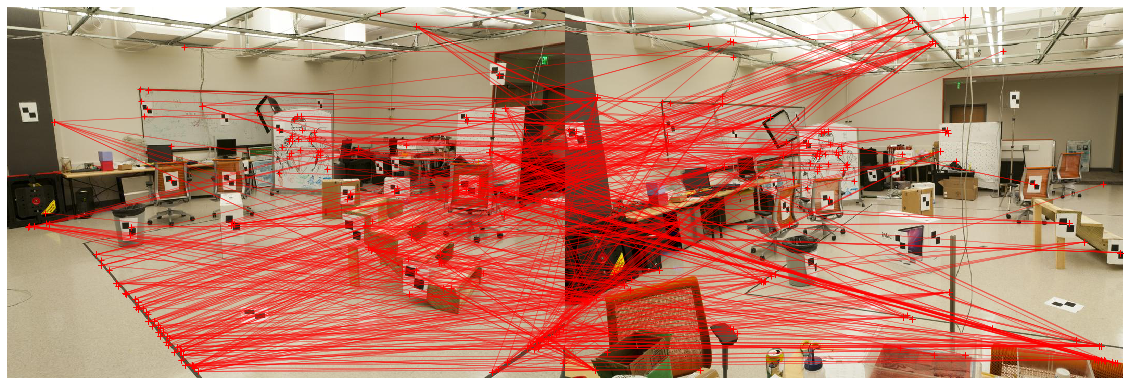

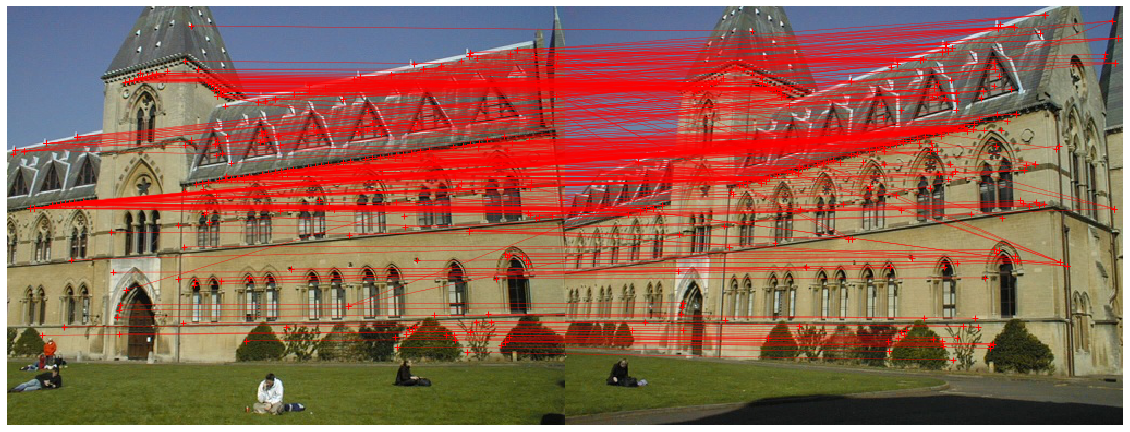

In [153]:
data_lab = get_best_matches(lab1, lab2, 500)
fig_lab, ax_lab = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax_lab, lab1, lab2, data_lab)

data_lib = get_best_matches(lib1, lib2, 500)
fig_lib, ax_lib = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax_lib, lib1, lib2, data_lib)

Average residual: 2.7166157587257898
Inliers: 20
lab: residual in frame 2 (normalized method) =  9.044306672139415
lab: residual in frame 1 (normalized method) =  10.86974603309003
lab: residual combined   (normalized method) =  9.957026352614722


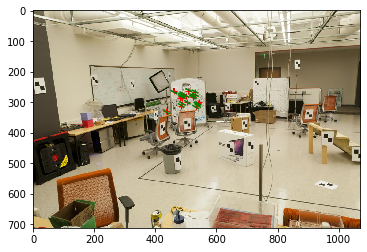

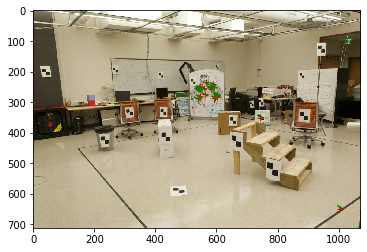

In [154]:
F_lab, matches_lab, max_inlier_lab, residue_lab = ransac(data, threshold=5, iterations=10000)
print("Average residual:", np.average(residue_lab))
print("Inliers:", max_inlier_lab)
pt1_2d = matches_lab[:, :2]
pt2_2d = matches_lab[:, 2:]
v2 = get_residual(F_lab, pt1_2d, pt2_2d)
v1 = get_residual(F_lab.T, pt2_2d, pt1_2d)
name = 'lab'
print('{:s}: residual in frame 2 (normalized method) = '.format(name), v2)
print('{:s}: residual in frame 1 (normalized method) = '.format(name), v1)
print('{:s}: residual combined   (normalized method) = '.format(name), (v1+v2)/2)
# Plot epipolar lines in image I2
fig, ax = plt.subplots()
plot_fundamental(ax, F_lab, pt1_2d, pt2_2d, lab2)
# Plot epipolar lines in image I1
fig, ax = plt.subplots()
plot_fundamental(ax, F_lab.T, pt2_2d, pt1_2d, lab1)

Average residual: 2.898540357432463
Inliers: 134
lib: residual in frame 2 (normalized method) =  11.964696755294646
lib: residual in frame 1 (normalized method) =  8.523764920752413
lib: residual combined   (normalized method) =  10.24423083802353


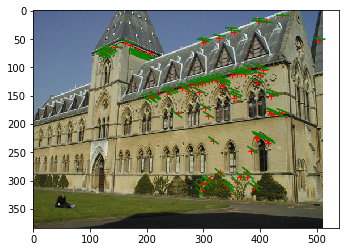

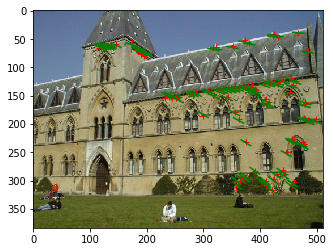

In [155]:
F_lib, matches_lib, max_inlier_lib, residue_lib = ransac(data_lib, threshold=5, iterations=10000)
print("Average residual:", np.average(residue_lib))
print("Inliers:", max_inlier_lib)
pt1_2d = matches_lib[:, :2]
pt2_2d = matches_lib[:, 2:]
v2 = get_residual(F_lib, pt1_2d, pt2_2d)
v1 = get_residual(F_lib.T, pt2_2d, pt1_2d)
name = 'lib'
print('{:s}: residual in frame 2 (normalized method) = '.format(name), v2)
print('{:s}: residual in frame 1 (normalized method) = '.format(name), v1)
print('{:s}: residual combined   (normalized method) = '.format(name), (v1+v2)/2)
# Plot epipolar lines in image I2
fig, ax = plt.subplots()
plot_fundamental(ax, F_lib, pt1_2d, pt2_2d, lib2)
# Plot epipolar lines in image I1
fig, ax = plt.subplots()
plot_fundamental(ax, F_lib.T, pt2_2d, pt1_2d, lib1)